# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Homework 5: Logistic Regression, High Dimensionality and PCA


**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas  https://canvas.harvard.edu/courses/42693/pages/homework-policies-and-submission-instructions.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.

Names of people you have worked with goes here: 

<hr style="height:2pt">

In [2]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

import math
from scipy.special import gamma

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from IPython.display import display


<div class='theme'> Cancer Classification from Gene Expressions </div>

In this problem, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The data set is provided in the file `data/dataset_hw5_1.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with 0 indicating the ALL class and 1 indicating the AML class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will use linear and logistic regression to build classification models for this data set. We will also use Principal Components Analysis (PCA) to reduce its dimensions. 



<div class='exercise'><b> Question 1 [25 pts]: Data Exploration </b></div>

First step is to  split  the observations into an approximate 50-50 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits).

**1.1** Take a peek at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.

**1.2** Notice that the resulting training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?  Explain in 3 or fewer sentences.

**1.3** Let's explore a few of the genes and see how well they discriminate between cancer classes. Create a single figure with four subplots arranged in a 2x2 grid. Consider the following four genes: `D29963_at`, `M23161_at`, `hum_alu_at`, and `AFFX-PheX-5_at`. For each gene overlay two histograms of the gene expression values on one of the subplots, one histogram for each cancer type. Does it appear that any of these genes discriminate between the two classes well? How are you able to tell?

**1.4** Since our data has dimensions that are not easily visualizable, we want to reduce the dimensionality of the data to make it easier to visualize. Using PCA, find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the two cancer types in different colors and different markers ('x' vs 'o', for example). How well do the top two principal components discriminate between the two classes? How much of the variance within the predictor set do these two principal components explain? 

**1.5** Plot the cumulative variance explained in the feature set as a function of the number of PCA-components (up to the first 50 components).  Do you feel 2 components is enough, and if not, how many components would you choose to consider?  Justify your choice in 3 or fewer sentences.  Finally, determine how many components are needed to explain at least 90% of the variability in the feature set. 

#### Answers:
First step is to split the observations into an approximate 50-50 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits).

In [3]:
np.random.seed(9002)
df = pd.read_csv('data/dataset_hw5_1.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

**1.1:** Take a peek at your training set...

In [4]:
# your code here
data_train.head()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,0,-214,-153,-58,88,-295,-558,199,-176,252,...,185,511,-125,389,-37,793,329,36,191,-37
2,0,-106,-125,-76,168,-230,-284,4,-122,70,...,156,649,57,504,-26,250,314,14,56,-25
5,0,-67,-93,84,25,-179,-323,-135,-127,-2,...,48,224,60,194,-10,291,41,8,-2,-80
9,0,-476,-213,-18,301,-403,-394,-42,-144,98,...,241,1214,127,255,50,1701,1108,61,525,-83
10,0,-81,-150,-119,78,-152,-340,-36,-141,96,...,186,573,-57,694,-19,636,205,17,127,-13


In [5]:
scaler = MinMaxScaler(copy=True).fit(data_train)
def scale(df,scaler):
    scaled_data = scaler.transform(df)
    return pd.DataFrame(scaled_data, columns = df.columns)
data_train = scale(data_train,scaler)
data_train.head()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,0.0,0.466192,0.739726,0.255814,0.246154,0.433190,0.240418,0.880427,0.625850,0.928074,...,0.385445,0.268542,0.398126,0.161897,0.677778,0.323241,0.322609,0.751381,0.069457,0.381720
1,0.0,0.658363,0.794521,0.213953,0.421978,0.573276,0.717770,0.741637,0.748299,0.505800,...,0.307278,0.356777,0.824356,0.206978,0.718519,0.081478,0.309565,0.629834,0.027597,0.446237
2,0.0,0.727758,0.857143,0.586047,0.107692,0.683190,0.649826,0.642705,0.736961,0.338747,...,0.016173,0.085038,0.831382,0.085457,0.777778,0.099733,0.072174,0.596685,0.009612,0.150538
3,0.0,0.000000,0.622309,0.348837,0.714286,0.200431,0.526132,0.708897,0.698413,0.570766,...,0.536388,0.718031,0.988290,0.109369,1.000000,0.727516,1.000000,0.889503,0.173023,0.134409
4,0.0,0.702847,0.745597,0.113953,0.224176,0.741379,0.620209,0.713167,0.705215,0.566125,...,0.388140,0.308184,0.557377,0.281458,0.744444,0.253339,0.214783,0.646409,0.049612,0.510753


In [6]:
data_test = scale(data_test,scaler)
data_test.head()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,0.0,0.606762,0.816047,1.006977,0.079121,0.165948,0.193380,0.851246,0.451247,0.457077,...,0.533693,0.475703,1.201405,0.077617,0.407407,0.249332,0.184348,0.276243,0.049302,0.091398
1,0.0,0.718861,0.757339,0.944186,0.173626,0.209052,0.252613,0.832028,0.619048,0.635731,...,-0.032345,0.465473,0.274005,0.068601,0.748148,0.477738,0.455652,0.607735,0.124651,0.354839
2,0.0,0.112100,0.530333,0.406977,0.048352,-0.096983,-0.163763,0.543060,-0.024943,0.505800,...,0.665768,0.343990,0.489461,0.127793,0.900000,0.770703,0.424348,0.878453,0.252403,0.688172
3,0.0,0.683274,0.806262,0.318605,0.432967,0.566810,0.817073,0.703915,0.884354,0.373550,...,0.460916,0.314578,0.697892,0.217170,0.670370,0.280053,0.299130,0.685083,0.033178,0.521505
4,0.0,0.656584,0.898239,0.097674,0.380220,0.627155,0.717770,0.620641,0.605442,0.345708,...,0.210243,0.403453,0.737705,0.139553,0.796296,0.056990,0.087826,0.723757,0.046202,0.483871


*your answer here* 


**1.2:** Notice that the resulting training set contains...

In [7]:
# your code here
data_train.shape

(40, 7130)

*your answer here*

When you have more predictors than samples, the classification problem becomes under specified. You will be able to arbitrarily draw a hyperplane that seperates your data, meaning that we are necessarily fitting to our data rather than our data generating distribution. Hence, we will over fit our model.

**1.3:** Let's explore a few of the genes...

/Users/joshfeldman/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


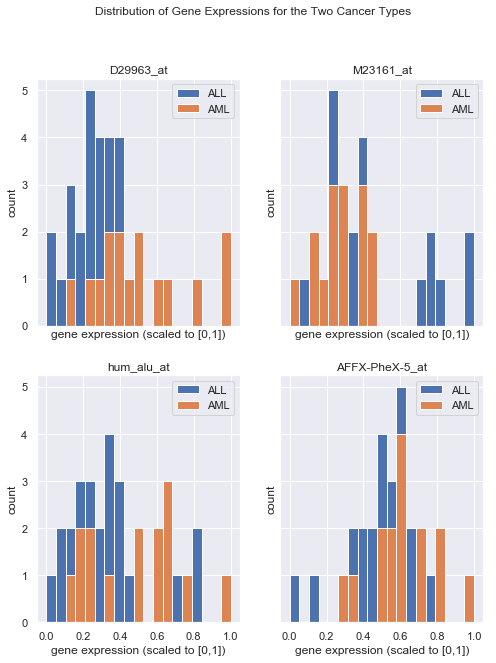

In [8]:
# your code here
genes = ['D29963_at', 'M23161_at', 'hum_alu_at', 'AFFX-PheX-5_at']
fig, axes = plt.subplots(2,2, sharex = True, sharey = True, figsize = (8,4))
genes_idx = 0
for row in axes:
    for ax in row:
        ax.hist(data_train[data_train.Cancer_type == 0][genes[genes_idx]], 
                bins = np.linspace(0,1,20), 
                label = 'ALL')
        ax.hist(data_train[data_train.Cancer_type == 1][genes[genes_idx]],
                bins = np.linspace(0,1,20), 
                label = 'AML')
        ax.legend()
        ax.set_xlabel('gene expression (scaled to [0,1])')
        ax.set_ylabel('count')
        ax.set_title(genes[genes_idx])
        genes_idx += 1
fig.set_figheight(10)
fig.suptitle("Distribution of Gene Expressions for the Two Cancer Types")
fig.show()

*your answer here*

None of these genes discriminate well between the two classes because the histograms have significant overlap.

**1.4:** Since our data has dimensions that are not easily visualizable...

In [9]:
# your code here
pca = PCA(n_components=2).fit(data_train.drop("Cancer_type", axis = 1))
data_train_2d = pca.transform(data_train.drop("Cancer_type", axis = 1))
data_train_2d = pd.DataFrame(data_train_2d, columns = ['pca1','pca2'])
data_train_2d['Cancer_type']= data_train['Cancer_type']

Text(0,0.5,'pca 2')

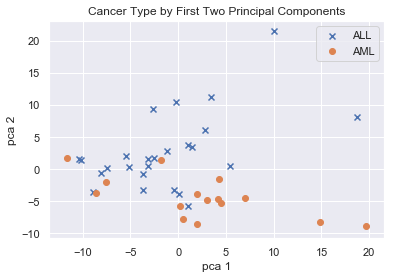

In [10]:
plt.scatter(data_train_2d[data_train_2d.Cancer_type == 0]['pca1'],
            data_train_2d[data_train_2d.Cancer_type == 0]['pca2'],
            label = 'ALL',
            marker = 'x'
           )
plt.scatter(data_train_2d[data_train_2d.Cancer_type == 1]['pca1'],
            data_train_2d[data_train_2d.Cancer_type == 1]['pca2'],
            label = 'AML',
            marker = 'o'
           )
plt.title('Cancer Type by First Two Principal Components')
plt.legend()
plt.xlabel('pca 1')
plt.ylabel('pca 2')

In [11]:
np.sum(pca.explained_variance_ratio_)

0.2731782945208866

*your answer here*

The first two principal components do not discrimenate well between the two cancers. Although there seem to be some regions that are all blue or all orange, there is still significant overlap. All hope is not lost, however, because the first two principal components only explain 27% of the variance in our data

**1.5**: Plot the cumulative variance explained in the feature set...

In [12]:
pca.components_.shape

(2, 7129)

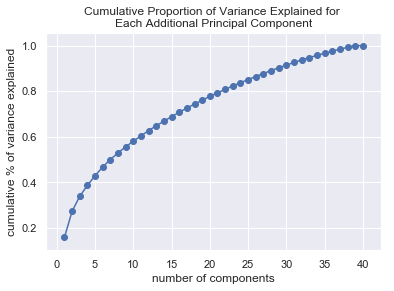

In [13]:
# your code here
# your code here
pca = PCA(n_components=40).fit(data_train.drop("Cancer_type", axis = 1))
plt.plot(np.arange(1,41),np.cumsum(pca.explained_variance_ratio_))
plt.scatter(np.arange(1,41),np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative % of variance explained')
plt.title('Cumulative Proportion of Variance Explained for \nEach Additional Principal Component')
plt.show()

In [14]:
np.sum(np.cumsum(pca.explained_variance_ratio_) < .90)

28

*your answer here*

Two components is not enough because, from our plot above, it doesn't discriminate between the two classes and they only explian 27% of the variance.

I would arbitrarily choose 10 data principal components, which explain ~60% of the variance in our data.

28 principle components are required to explain 90% of the variance.

<div class='exercise'> <b> Question 2 [25 pts]: Linear Regression vs. Logistic Regression </b> </div>

In class we discussed how to use both linear regression and logistic regression for classification. For this question, you will work with a single gene predictor, `D29963_at`, to explore these two methods.

**2.1** Fit a simple linear regression model to the training set using the single gene predictor `D29963_at` to predict cancer type and plot the histogram of predicted values. We could interpret the scores predicted by the regression model for a patient as an estimate of the probability that the patient has `Cancer_type`=1 (AML). Is there a problem with this interpretation?

**2.2** The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary classes 0 or 1) by classifying patients with predicted score greater than 0.5 into `Cancer_type`=1, and the others into the `Cancer_type`=0. Evaluate the classification accuracy of the obtained classification model on both the training and test sets.

**2.3** Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? If there are no substantial differences, why do you think this happens? 

Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to **not** regularize (use 'C=100000').  

**2.4** Create a figure with 4 items displayed on the same plot:
- the quantitative response from the linear regression model as a function of the gene predictor `D29963_at`.
- the predicted probabilities of the logistic regression model as a function of the gene predictor `D29963_at`.  
- the true binary response for the test set points for both models in the same plot. 
- a horizontal line at $y=0.5$. 

Based on these plots, does one of the models appear better suited for binary classification than the other?  Explain in 3 sentences or fewer. 




#### Answers: 

**2.1:** Fit a simple linear regression model to the training set

Text(0.5,1,'Distribution of predicted "probability" of cancer type')

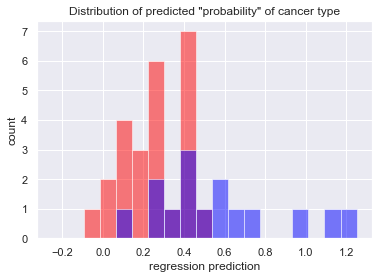

In [15]:
# your code here
lin_model = OLS(data_train['Cancer_type'], sm.add_constant(data_train['D29963_at'])).fit()
cancer_0_lin_reg = lin_model.predict(sm.add_constant(data_train[data_train['Cancer_type'] == 0]['D29963_at']))
cancer_1_lin_reg = lin_model.predict(sm.add_constant(data_train[data_train['Cancer_type'] == 1]['D29963_at']))
plt.hist(cancer_0_lin_reg, bins = np.linspace(-0.25,1.25,20), color = 'red', label = 'ALL', alpha = .5)
plt.hist(cancer_1_lin_reg, bins = np.linspace(-0.25,1.25,20), color = 'blue', label = 'AML', alpha = .5)
plt.xlabel('regression prediction')
plt.ylabel('count')
plt.title('Distribution of predicted "probability" of cancer type')

*your answer here*
The problem with interpreting the predicted values as probabilities is that they are not limited to the [0,1] range

**2.2:** The fitted linear regression model can be converted to a classification model...

In [16]:
# your code here
predictions_train = lin_model.predict(sm.add_constant(data_train['D29963_at']))
classifications_train = [1 if p > 0.5 else 0 for p in predictions_train]
train_acc = accuracy_score(data_train.Cancer_type, classifications_train)
print('Training data accuracy:',train_acc)

Training data accuracy: 0.8


In [17]:
predictions_test = lin_model.predict(sm.add_constant(data_test['D29963_at']))
classifications_test = [1 if p > 0.5 else 0 for p in predictions_test]
test_acc = accuracy_score(data_test.Cancer_type, classifications_test)
print('Testing data accuracy:',test_acc)

Testing data accuracy: 0.7575757575757576


*your answer here*


**2.3:** Next, fit a simple logistic regression model to the training set...

In [18]:
# your code here
log_model = (LogisticRegression(C = 100000)
             .fit(np.array(data_train['D29963_at']).reshape(-1, 1), data_train['Cancer_type'])
            )
# make predictions
train_pred_log = log_model.predict(np.array(data_train['D29963_at']).reshape(-1, 1))
test_pred_log = log_model.predict(np.array(data_test['D29963_at']).reshape(-1, 1))

# calculate accuracy
train_acc_log = accuracy_score(data_train.Cancer_type, train_pred_log)
print('Training data accuracy:',train_acc_log)
test_acc_log = accuracy_score(data_test.Cancer_type, test_pred_log)
print('Test data accuracy:',test_acc_log)

Training data accuracy: 0.8
Test data accuracy: 0.7575757575757576


*your answer here*

The linear regression and the logistic regression give the same results. This is because the linear regression and the logistic regression cross the 0.5 probability threshold at approximately the same gene expression value (see plot below).  <font color = 'red'> **IS THIS RIGHT?**

**2.4** Create a figure with 4 items displayed on the same plot:
- the quantitative response from the linear regression model as a function of the gene predictor `D29963_at`.
- the predicted probabilities of the logistic regression model as a function of the gene predictor `D29963_at`.  
- the true binary response for the test set points for both models in the same plot. 
- a horizontal line at $y=0.5$. 

Based on these plots, does one of the models appear better suited for binary classification than the other?  Explain in 3 sentences or fewer. 



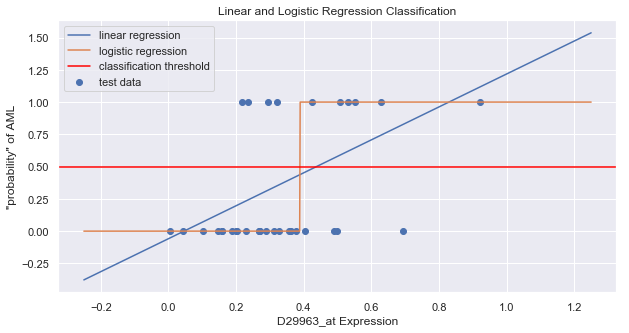

In [34]:
# your code here
plt.figure(figsize=(10,5))
gene_expression = np.linspace(-0.25,1.25,1000)
plt.plot(gene_expression, 
         lin_model.predict(sm.add_constant(gene_expression)),
         label = 'linear regression')
plt.plot(gene_expression, 
         log_model.predict(gene_expression.reshape(-1,1)),
         label='logistic regression'
        )
plt.scatter(data_test['D29963_at'],
            data_test['Cancer_type'],
            label = 'test data'
           )
plt.axhline(0.5,c = 'red', label = 'classification threshold')
plt.xlabel("D29963_at Expression")
plt.ylabel('"probability" of AML')
plt.title('Linear and Logistic Regression Classification')
plt.legend(loc = 2)


Logistic regression is better suited to binary classification because it only predicts values between 0 and 1, which are valid probabilities. Additionally, linear regression is less robust to extreme values. As we can see in the plot, the sample with a high D29963_at expression appears to decrease the slope of the linear regression, whereas linear regression simply predicts a value very close to 1.

*your answer here*


<div class='exercise'> <b> Question 3 [30pts]: Multiple Logistic Regression </b> </div>


**3.1** Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?  


**3.2** How many of the coefficients estimated by this multiple logistic regression in the previous part are significantly different from zero at a *significance level of 5%*? Use the same value of C=100000 as before.

**Hint:** To answer this question, use *bootstrapping* with 1000 boostrap samples/iterations.  

**3.3** Use the `visualize_prob` function provided below (or any other visualization) to visualize the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. The function creates a visualization that places the data points on a vertical line based on the predicted probabilities, with the different cancer classes shown in different colors, and with the 0.5 threshold highlighted using a dotted horizontal line. Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?

**3.4** Open question: Comment on the classification accuracy of the train and test sets. Given the results above how would you assess the generalization capacity of your trained model?  What other tests or approaches would you suggest to better guard against the false sense of security on the accuracy of the model as a whole. 


In [75]:
#--------  visualize_prob
# A function to visualize the probabilities predicted by a Logistic Regression model
# Input: 
#      model (Logistic regression model)
#      x (n x d array of predictors in training data)
#      y (n x 1 array of response variable vals in training data: 0 or 1)
#      ax (an axis object to generate the plot)

def visualize_prob(model, x, y, ax):
    # Use the model to predict probabilities for x
    y_pred = model.predict_proba(x)
    
    # Separate the predictions on the label 1 and label 0 points
    ypos = y_pred[y==1]
    yneg = y_pred[y==0]
    
    # Count the number of label 1 and label 0 points
    npos = ypos.shape[0]
    nneg = yneg.shape[0]
    
    # Plot the probabilities on a vertical line at x = 0, 
    # with the positive points in blue and negative points in red
    pos_handle = ax.plot(np.zeros((npos,1)), ypos[:,1], 'bo', label = 'Cancer Type 1')
    neg_handle = ax.plot(np.zeros((nneg,1)), yneg[:,1], 'ro', label = 'Cancer Type 0')

    # Line to mark prob 0.5
    ax.axhline(y = 0.5, color = 'k', linestyle = '--')
    
    # Add y-label and legend, do not display x-axis, set y-axis limit
    ax.set_ylabel('Probability of AML class')
    ax.legend(loc = 'best')
    ax.get_xaxis().set_visible(False)
    ax.set_ylim([0,1])

#### Answers:

**3.1:** Next, fit a multiple logistic regression model with all the gene predictors...

In [40]:
# your code here
multiple_log_model = (LogisticRegression(C = 100000)
                      .fit(data_train.drop('Cancer_type', axis = 1), data_train.Cancer_type)
                     )

In [41]:
train_prob = multiple_log_model.predict(data_train.drop('Cancer_type', axis = 1))
train_class = [1 if p > 0.5 else 0 for p in train_prob]
train_acc = accuracy_score(data_train.Cancer_type, train_class)
print("training accuracy:", train_acc)

test_prob = multiple_log_model.predict(data_test.drop('Cancer_type', axis = 1))
test_class = [1 if p > 0.5 else 0 for p in test_prob]
test_acc = accuracy_score(data_test.Cancer_type, test_class)
print("test accuracy:", test_acc)

training accuracy: 1.0
test accuracy: 1.0


*your answer here*

This model performs better on both the training and the test sets

**3.2:** How many of the coefficients estimated by this multiple logistic regression...

In [59]:
# bootstrapping code
# your code here
bootstrap_data = [data_train.sample(data_train.shape[0], replace = True) for _ in range(1000)]
fit_log_model = lambda df: LogisticRegression(C = 100000).fit(df.drop('Cancer_type', axis = 1), df.Cancer_type)
models = [fit_log_model(df) for df in bootstrap_data]
coefs = np.array([m.coef_[0] for m in models])

In [73]:
prop_greater_than_0 = np.sum(coefs > 0,axis = 0)/coefs.shape[0]
prop_less_than_0 = np.sum(coefs < 0,axis = 0)/coefs.shape[0]
significant_params = np.sum(prop_greater_than_0 > .95) + np.sum(prop_less_than_0 > .95)
print("{} parameters out of {} parameters are significantly different from 0".format(significant_params, coefs.shape[1]))

2389 parameters out of 7129 parameters are significantly different from 0


*your answer here*


**3.3:** Use the visualize_prob function provided below ...

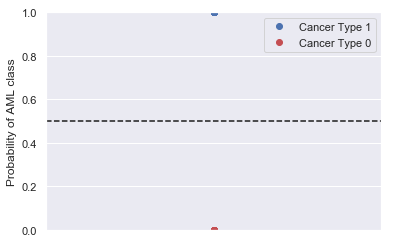

In [77]:
""" Plot classification model """

# your code here
visualize_prob(multiple_log_model, data_train.drop('Cancer_type', axis = 1), data_train.Cancer_type, plt.axes())

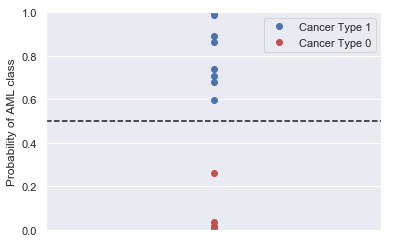

In [79]:
visualize_prob(multiple_log_model, data_test.drop('Cancer_type', axis = 1), data_test.Cancer_type, plt.axes())

*your answer here*

**Is there a difference in the spread of probabilities in the training and test plots?**

In the training plots, the probabilities are either 0 or 1. In the test plot, the probabilities have higher variance.

**Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?**

In the test set, there are some points that are close to p = 0.5. We should be less confident in the classification made by our model in these cases.

**3.4:** Open question: Comment on the classification accuracy...


*your answer here* 

**Comment on the classification accuracy of the train and test sets.**

The model classifies the training and test sets perfectly.

**Given the results above how would you assess the generalization capacity of your trained model?**

Though the model has perfect accuracy on the test set, we see that the model isn't very certain about some of the test set predictions. This means that we potentially just got lucky that these points ended up on the correct side of the 0.5 classification threshold.

**What other tests or approaches would you suggest to better guard against the false sense of security on the accuracy of the model as a whole.**

There are three things we can do:

1) Evaluate our model using the ROC instead of accuracy. The ROC evaluates the model based on the predicted probabilities rather than the predicted classes, which means that uncertain predictions will be taken into account

2) Collect more data for our test set to get a better sense of the performance of our test set

3) Conduct cross-validation to get a better estimate of the performance of our model.


<div class='exercise'><b> Question 4 [20 pts]: PCR: Principal Components Regression </b></div>

High dimensional problems can lead to problematic behavior in model estimation (and make prediction on a test set worse), thus we often want to try to reduce the dimensionality of our problems. A reasonable approach to reduce the dimensionality of the data is to use PCA and fit a logistic regression model on the smallest set of principal components that explain at least 90% of the variance in the predictors.

**4.1:** Fit two separate Logistic Regression models using principal components as the predictors: (1) with the number of components you selected from problem 1.5 and (2) with the number of components that explain at least 90% of the variability in the feature set. How do the classification accuracy values on both the training and tests sets compare with the models fit in question 3?   

**4.2:** Use the code provided in question 3 (or your choice of visualization) to visualize the probabilities predicted by the fitted models in the previous part on both the training and test sets. How does the spread of probabilities in these plots compare to those for the model in question 3.2? If the lower dimensional representation yields comparable predictive power, what advantage does the lower dimensional representation provide?


#### Answers:

**4.1:** Fit two separate Logistic Regression models...

In [107]:
# your code here
components_60 = 10

data_train_60 = pca.transform(data_train.drop('Cancer_type', axis = 1))[:,:components_60]
log_reg_60 = LogisticRegression(C = 100000).fit(data_train_60,data_train['Cancer_type'])
train_pred_60 = log_reg_60.predict(data_train_60)
train_acc_60 = accuracy_score(data_train['Cancer_type'],train_pred_60)
print('training accuracy on principle components explaining 60% of variance:',train_acc_60)

data_test_60 = pca.transform(data_test.drop('Cancer_type', axis = 1))[:,:components_60]
test_pred_60 = log_reg_60.predict(data_test_60)
test_acc_60 = accuracy_score(data_test['Cancer_type'],test_pred_60)
print('test accuracy on principle components explaining 60% of variance:',test_acc_60)

training accuracy on principle components explaining 60% of variance: 1.0
test accuracy on principle components explaining 60% of variance: 0.8787878787878788


In [98]:
# your code here
components_90 = 28

data_train_90 = pca.transform(data_train.drop('Cancer_type', axis = 1))[:,:components_90]
log_reg_90 = LogisticRegression(C = 100000).fit(data_train_90,data_train['Cancer_type'])
train_pred_90 = log_reg_90.predict(data_train_90)
train_acc_90 = accuracy_score(data_train['Cancer_type'],train_pred_90)
print('training accuracy on principle components explaining 90% of variance:',train_acc_90)

data_test_90 = pca.transform(data_test.drop('Cancer_type', axis = 1))[:,:components_90]
test_pred_90 = log_reg_90.predict(data_test_90)
test_acc_90 = accuracy_score(data_test['Cancer_type'],test_pred_90)
print('test accuracy on principle components explaining 90% of variance:',test_acc_90)

training accuracy on principle components explaining 90% of variance: 1.0
test accuracy on principle components explaining 90% of variance: 0.9696969696969697


*your answer here*

The test set accuracy is better when we use more principal components.

**4.2:** Use the code provided in question 3...

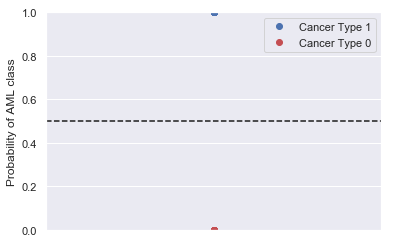

In [99]:
# your code here
visualize_prob(log_reg_90, data_train_90, data_train.Cancer_type, plt.axes())

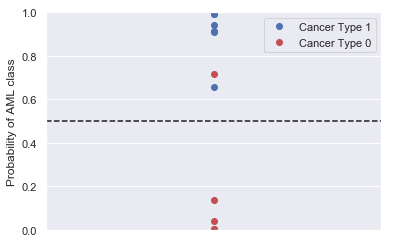

In [100]:
visualize_prob(log_reg_90, data_test_90, data_test.Cancer_type, plt.axes())

*your answer here*

**How does the spread of probabilities in these plots compare to those for the model in question 3.2?**

These probabilities are almost identical to those in question 3.2.

**If the lower dimensional representation yields comparable predictive power, what advantage does the lower dimensional representation provide?**

The lower dimensional representation provides greater interpretability because we can look at the significant coefficients in the model and then examine the principal componenets corresponding to these important coeffecients. Hopefully, the combination of the original features that make up these principal components are significant in the context of our problem.

Additionally, the principal componenets are chosen to reduce the collinearities in our dataset, meaning that the covariance and standard error of our coefficients will be lower. This means we can more easily identify significant coefficients.